# ***Assignment 1.2 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

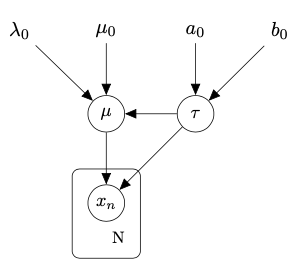

### ***Question 1.2.7:***

Implement a function that generates data points for the given model.

In [1]:
import numpy as np
def generate_data(mu, tau, N):
  # Insert your code here
  D = np.random.normal(mu, 1/tau, N)
  return D


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



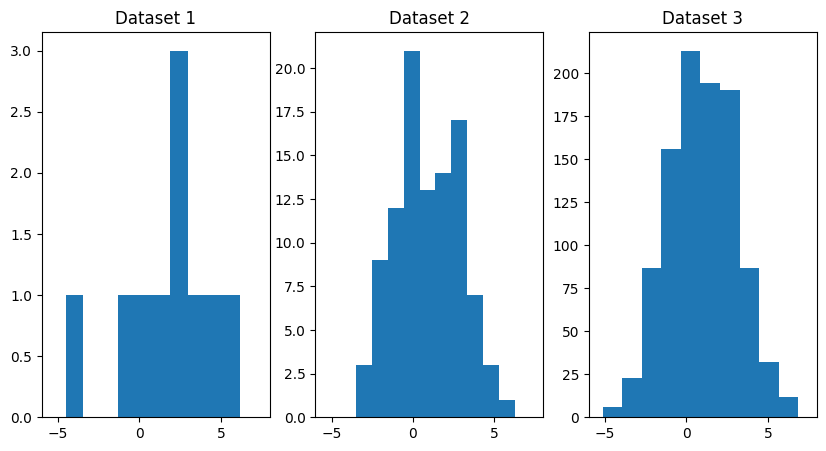

In [11]:
import matplotlib.pyplot as plt
mu = 1
tau = 0.5

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)

# Visulaize the datasets via histograms
# Insert your code here
plt.figure(figsize=[10, 5])
plt.subplot(1,3,1)
plt.xlim([-6,8])
plt.hist(dataset_1)
plt.title("Dataset 1")
plt.subplot(1,3,2)
plt.hist(dataset_2)
plt.xlim([-6,8])
plt.title("Dataset 2")
plt.subplot(1,3,3)
plt.hist(dataset_3)
plt.title("Dataset 3")
plt.xlim([-6,8])
plt.show()

### ***Question 1.2.8:***

Find ML estimates of the variables μ and τ

In [ ]:
def ML_est(data):
  # insert your code
  N = np.shape(data)[0]
  sum_xn = np.sum(data)
  mu_ml = (lambda_0 * mu_0 + sum_xn) / (N + lambda_0)
  tau_ml = ((N-3)/2 + a_0) / (1/2 * np.sum((data - mu_ml)**2) + lambda_0/2 * (mu_ml - mu_0)**2 + b_0)
  return mu_ml, tau_ml

### ***Question 1.2.9:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


In [ ]:
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
  # your implementation
  N = np.shape(D)[0]
  a_0_prime = N/2 + a_0
  b_0_prime = b_0 + 1/2 * (np.sum(D**2) + lambda_0 * mu_0**2) - 1/2 * (mu_0 * lambda_0 + np.sum(D))**2 / (N + lambda_0)
  mu_0_prime = (lambda_0 * mu_0 + np.sum(D)) / (N + lambda_0)
  lambda_0_prime = N + lambda_0
  exact_post_dist_parameters = [a_0_prime, b_0_prime, mu_0_prime, lambda_0_prime]
  return exact_post_dist_parameters

### ***Question 1.2.10:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [ ]:
# prior parameters
mu_0 =
lambda_0 =
a_0 =
b_0 =

Continue with a helper function that computes ELBO:


In [ ]:
from scipy.stats import gamma, norm
def compute_elbo (D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N):
  # given the prior and posterior parameters together with the data,
  # compute ELBO here


  return elbo


Now, implement the CAVI algorithm:

In [ ]:
def CAVI(D, a_0, b_0, mu_0, lambda_0):
  # make an initial guess for the expected value of tau
  initial_guess_exp_tau =

  # CAVI iterations ...
    # save ELBO for each iteration, plot them afterwards to show convergence

  return a_N, b_N, mu_N, lambda_N, elbos

Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.


In [1]:
# Insert your main code here


# Example flow for dataset_2:
  ##  mu_ml, tau_ml = ML_est(dataset_2)
  ##  a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_2, a_0, b_0, mu_0, lambda_0)
  ##  plot elbos, show convergence
  ##  exact_post_dist_param = compute_exact_posterior(dataset_2, a_0, b_0, mu_0, lambda_0)
  ##  compare exact_post_dist with the CAVI result ( = q(a_N, b_N, mu_N, lambda_N) ) using for ex. contour plots, show also ML estimate on this plot


